This notebook is to call a copy of the model weights from the fun1 (just to prevent contamination) and to plot an ROC curve for it.

In [17]:
import matplotlib.pyplot as plt
import numpy as np

import os
import pandas as pd
import keras
import h5py

from keras.models import Model
from sklearn.model_selection import train_test_split


import tensorflow as tf
tf.random.set_seed(812)
from keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization, concatenate
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import roc_curve, auc

In [18]:
def extract_data_from_hdf5(file_path, filter_qso=False):
    classifier, name, spectra, redshift = [], [], [], []
    with h5py.File(file_path, "r") as hdf5_file:
        classifier = hdf5_file["classifier"][:]
        name = hdf5_file["name"][:]
        spectra = hdf5_file["spectra"][:]
        redshift = hdf5_file["redshift"][:]
    
    if filter_qso:
        # Filter out "QSO" entries
        indices_to_keep = [i for i, cls in enumerate(classifier) if cls != b'QSO']
        classifier = [classifier[i] for i in indices_to_keep]
        name = [name[i] for i in indices_to_keep]
        spectra = [spectra[i] for i in indices_to_keep]
        redshift = [redshift[i] for i in indices_to_keep]
    
    return classifier, [n.decode() for n in name], spectra, redshift

def call_arrays(hdf5_directory_1, hdf5_directory_2):
    hdf5_files_1 = sorted([f for f in os.listdir(hdf5_directory_1) if f.endswith(".h5")])
    
    # List all HDF5 files in the second directory and sort them by name
    hdf5_files_2 = sorted([f for f in os.listdir(hdf5_directory_2) if f.endswith(".h5")])
    
    # Initialize arrays to store data
    all_classifiers, all_names, all_spectra, all_redshifts = [], [], [], []
    
    # Iterate over HDF5 files in the first directory
    for filename in hdf5_files_1:
        file_path = os.path.join(hdf5_directory_1, filename)
        
        # Extract data from the HDF5 file and filter out "QSO"
        classifier, name, spectra, redshift = extract_data_from_hdf5(file_path, filter_qso=False)
        
        # Append the data to the respective arrays
        all_classifiers.extend(classifier)
        all_names.extend(name)
        all_spectra.extend(spectra)
        all_redshifts.extend(redshift)
    
    # Iterate over HDF5 files in the second directory
    for filename in hdf5_files_2:
        file_path = os.path.join(hdf5_directory_2, filename)
        
        # Extract data from the HDF5 file without filtering
        classifier, name, spectra, redshift = extract_data_from_hdf5(file_path, filter_qso=False)
        
        # Append the data to the respective arrays
        all_classifiers.extend(classifier)
        all_names.extend(name)
        all_spectra.extend(spectra)
        all_redshifts.extend(redshift)
    
    return all_classifiers, all_names, all_spectra, all_redshifts

In [19]:

def f1_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    return tf.py_function(f1_score, (y_true, y_pred), tf.double)
    
def network(X_train, Norm_TRain, Norm_valid, y_train, y_validation, lr, do, input_layer, n_node_CNN, n_node_FC):

    input_shape = (len(X_train.iloc[1]), 1)  # Assuming each element in X_train is a 1D array
    
    # Input layer
    inputs = Input(shape=input_shape)

    x = Conv1D(input_layer, kernel_size=5, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    for j, k in enumerate(n_node_CNN): 
        x = Conv1D(k, kernel_size=5, activation='relu')(x)
        if j<(len(n_node_CNN)): 
            x = MaxPooling1D(pool_size=2)(x)

    
    # Flatten the output
    x = Flatten()(x)
    
    # Fully Connected Layer
    for i, n in enumerate(n_node_FC): 
        x = Dense(n, activation='relu')(x)
        if i<(len(n_node_FC)-1): 
            x = Dropout(do)(x)
    
    # Output layer with sigmoid activation for binary classification
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Create the model
    mod1 = Model(inputs=inputs, outputs=outputs)
    
    # Define optimizer and metrics
    initial_learning_rate = lr
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
    
    # Compile the model with custom F1 metric
    mod1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1_metric, 'AUC'])
    
    # Print model summary
    mod1.summary()
    return mod1

In [20]:
def get_plots(all_classifiers, all_names, all_spectra, all_redshifts, lr, do, input_layer, n_node_CNN,  n_node_FC, weight_path):
    data = []
    for i in range(0, len(all_redshifts)):
        spec = pd.DataFrame(all_spectra[i])
        spec_arr = spec[1]
        data.append(spec_arr)

    pdata = pd.DataFrame(data)

    # Retrieve the labels
    labels = np.zeros(len(all_classifiers))
    for i, id in enumerate(all_classifiers):
        if b'QSO' in id:
            labels[i] = 0  # This is not a lens
        else:
            labels[i] = 1  # This is a lens

    labels = labels.reshape(1, -1).T
    X_train, X_validation, y_train, y_validation = train_test_split(pdata, labels, train_size=0.7)
    deviat = np.std(X_train)
    mean = np.mean(X_train)

    valid_deviat = np.std(X_validation)
    valid_mean = np.mean(X_validation)

    Norm_TRain = (X_train - mean) / deviat
    Norm_valid = (X_validation - valid_mean) / valid_deviat

    Norm_TRain_reshaped = np.expand_dims(Norm_TRain, axis=-1)

    # Similarly, reshape the validation data if needed
    Norm_valid_reshaped = np.expand_dims(Norm_valid, axis=-1)

    mod1 = network(X_train, Norm_TRain_reshaped, Norm_valid_reshaped, y_train, y_validation, lr, do, input_layer,
                   n_node_CNN, n_node_FC)

    mod1.load_weights(weight_path)

    predictions = mod1.predict(Norm_valid_reshaped)

    fpr, tpr, thresholds = roc_curve(y_validation, predictions)

    # Choose desired specificity

    desired_fpr = 0.01
    index = np.argmin(np.abs(fpr - desired_fpr))

    # TPR at the specified FPR
    desired_tpr = tpr[index]

    # Compute Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Save the ROC curve data
    roc_data = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc, 'desired':desired_tpr, 'desired_fpr':desired_fpr, 'index':index}

    print(desired_tpr, roc_auc)

    return roc_data

def plot_multi_roc(all_roc_data):
    plt.figure()

    for i, roc_data in enumerate(all_roc_data):
        fpr = roc_data['fpr']
        tpr = roc_data['tpr']
        roc_auc = roc_data['roc_auc']
        desired = roc_data['desired']
        index = roc_data['index']
        desired_fpr = roc_data['desired_fpr']

        label = f'Configuration {i + 1}'  # Explicitly set the label for each line
        plt.plot(fpr, tpr, lw=2, label=label)

    # Plot the diagonal line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[index], tpr[index], color='red', label=f'FPR={desired_fpr:.3f}, TPR={desired:.3f}', s=50)
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.xlim([0, 0.2])  # Adjust the limits accordingly for log scale
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - Multiple Runs')

    # Explicitly set legend labels based on the number of runs
    plt.legend([f'Configuration {i + 1}' for i in range(len(all_roc_data))], loc="lower right")

    plt.show()

    plt.figure()

    for i, roc_data in enumerate(all_roc_data):
        fpr = roc_data['fpr']
        tpr = roc_data['tpr']
        roc_auc = roc_data['roc_auc']

        label = f'Configuration {i + 1}'  # Explicitly set the label for each line
        plt.plot(fpr, tpr, lw=2, label=label)

    # Plot the diagonal line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([0, 1.0])  # Adjust the limits accordingly for log scale
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - Multiple Runs')

    # Explicitly set legend labels based on the number of runs
    plt.legend([f'Configuration {i + 1}' for i in range(len(all_roc_data))], loc="lower right")

    plt.show()

In [21]:
def array_user(hdf5_directory_1, hdf5_directory_2, dic, weight_path):
    all_classifiers, all_names, all_spectra, all_redshifts = call_arrays(hdf5_directory_1, hdf5_directory_2)

    lrs = dic['lr'] #learning rate
    dos = dic['do'] #dropout
    input_layer = dic['input_layer'] #first layer of cnn
    n_node_CNN = dic['n_node_CNN'] #cnn layers
    n_node_FC = dic['n_node_FC']
    weight_path = dic['weight_path'] #fully connected layer
    
    roc_data = get_plots(all_classifiers, all_names, all_spectra, all_redshifts, lrs, dos, input_layer, n_node_CNN,  n_node_FC, weight_path)
    
    return roc_data

/Users/emac/anaconda3/envs/MachineLearning/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7781, 1)]         0         
                                                                 
 conv1d_12 (Conv1D)          (None, 7777, 50)          300       
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 3888, 50)          0         
 ng1D)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 3884, 100)         25100     
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 1942, 100)         0         
 ng1D)                                                           
                                                                 
 conv1d_14 (Conv1D)          (None, 1938, 100)         5010

/var/folders/q2/w8lwsqgj6gd5ctf_8248mphm0000gn/T/ipykernel_1277/499871026.py:79: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 0.2])  # Adjust the limits accordingly for log scale


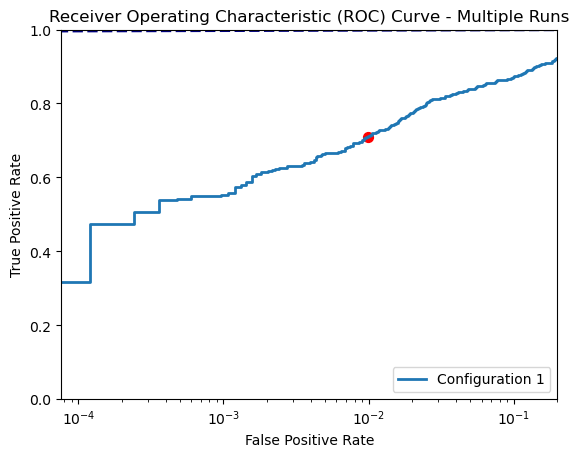

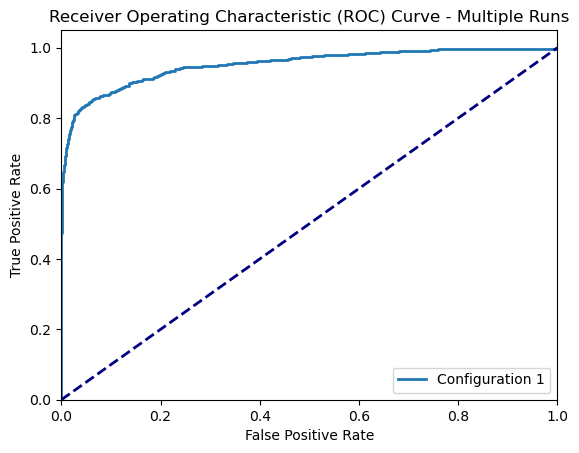

In [22]:
all_roc_data = []
weight_path3 = '/Users/emac/Library/CloudStorage/GoogleDrive-edm2158@stanford.edu/My Drive/DESI_Project/CNN\'s MLP\'s/CNN/SherlockTestPyFiles/CNN/CNN/Model Weights/model_weights_5_copy.h5'
weight_path2 = '/Users/emac/Library/CloudStorage/GoogleDrive-edm2158@stanford.edu/My Drive/DESI_Project/CNN\'s MLP\'s/CNN/SherlockTestPyFiles/CNN/CNN/Model Weights/model_weights_4_copy.h5'
weight_path = '/Users/emac/Library/CloudStorage/GoogleDrive-edm2158@stanford.edu/My Drive/DESI_Project/CNN\'s MLP\'s/CNN/SherlockTestPyFiles/CNN/CNN/Model Weights/model_weights_3_copy.h5'

hdf5_directory_1 = '/Users/emac/Library/CloudStorage/GoogleDrive-edm2158@stanford.edu/My Drive/DESI_Project/CNN\'s MLP\'s/TrainingSample/TrainingSample_no_rebin/QSO(unlensed)'  # Directory 1
hdf5_directory_2 = '/Users/emac/Library/CloudStorage/GoogleDrive-edm2158@stanford.edu/My Drive/DESI_Project/CNN\'s MLP\'s/TrainingSample/TrainingSample_no_rebin/Lense_files'  # Directory 2


config1 = {'lr':[1e-3], 'do':0, 'input_layer':50, 'n_node_CNN':[100, 100, 100, 100, 100], 'n_node_FC':[30, 25], 'weight_path':weight_path}
config2 = {'lr':[1e-3], 'do':0.05, 'input_layer':50, 'n_node_CNN':[50, 50, 50, 50, 50, 50], 'n_node_FC':[30, 25], 'weight_path':weight_path2}
config3 = {'lr':[1e-3], 'do':0, 'input_layer':50, 'n_node_CNN':[100, 100, 100, 100, 100], 'n_node_FC':[30, 25], 'weight_path':weight_path3}

configs = [config1]

for cof in configs:
    roc_data = array_user(hdf5_directory_1, hdf5_directory_2, cof, weight_path)

    all_roc_data.append(roc_data)

# After all runs are completed, call plot_multi_roc
plot_multi_roc(all_roc_data)

In [23]:
all_roc_data

[{'fpr': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.20105693e-04,
         1.20105693e-04, 2.40211386e-04, 2.40211386e-04, 3.60317079e-04,
         3.60317079e-04, 4.80422772e-04, 4.80422772e-04, 6.00528465e-04,
         6.00528465e-04, 8.40739851e-04, 8.40739851e-04, 9.60845544e-04,
         9.60845544e-04, 1.08095124e-03, 1.08095124e-03, 1.20105693e-03,
         1.20105693e-03, 1.32116262e-03, 1.32116262e-03, 1.44126832e-03,
         1.44126832e-03, 1.56137401e-03, 1.56137401e-03, 1.68147970e-03,
         1.68147970e-03, 1.80158540e-03, 1.80158540e-03, 1.92169109e-03,
         1.92169109e-03, 2.04179678e-03, 2.0